<a href="https://colab.research.google.com/github/NeulboGom/J_Automation_Project/blob/JH/Anomaly_Detection_ResNet152v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
import albumentations as albu
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Conv2D, Dense, Dropout
from tqdm import tqdm

# 모델 가져오기

## ResNet50 모델을 가져온다
 - 데이터 수는 적고, ImageNet 데이터와 차이가 많이 나기 때문에
   일부 layer는 고정하고, 적당한 양의 layer는 fine tuning 및 classifier 추가
  

In [ ]:
# 모델 불러오기
resnet_model = keras.applications.resnet_v2.ResNet152V2(weights = None,
                                             include_top = False,
                                             pooling = None, # pooling을 None으로 설정하여 마지막 레이어 뒤에 추가 레이어를 연결할 수 있도록 함
                                             input_tensor = Input(shape = (224, 224, 3)),
                                             classes = 3)

'''
include_top: 네트워크에 FC-layer, 즉 Classifier를 넣을지 말지 Boolean (커스텀 할지 말지 여부 결정)
weights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기
input_tensor: 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))
pooling: include_top이 False일 때 None, avg, max 중 선택
classes: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수
'''

"\ninclude_top: 네트워크에 FC-layer, 즉 Classifier를 넣을지 말지 Boolean (커스텀 할지 말지 여부 결정)\nweights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기\ninput_tensor: 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))\npooling: include_top이 False일 때 None, avg, max 중 선택\nclasses: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수\n"

In [ ]:
res_edit_model.summary()

### 일부 layer 고정해서 fine tuning

In [ ]:
# ResNet50 모델 안 layer들 중 마지막 5개를 제외한 나머지 layer들은 고정
for layer in resnet_model.layers[:-25]:
  layer.trainable = False

In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

# 최상위 레이어 추가 및 3개 클래스에 대한 Dense layer(Classifier 제작)
x = resnet_model.layers[-1].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(3, activation = 'softmax')(x)

# 수정된 레이어를 포함하는 모델
res_edit_model = Model(inputs = resnet_model.input, outputs = outputs)

# 이미지 데이터 전처리

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    # 이미지 파일 경로 불러오기
    image_list = glob(os.path.join(image_path, '*.png'))

    # 빈 numpy 배열 생성 (4차원 배열로 초기화)
    img_array = np.empty((len(image_list), *target_size, 3), dtype=np.uint8)

    for i, img in enumerate(image_list):
        image = Image.open(img)
        image = image.resize(target_size)

        # 흑백 이미지를 3차원 RGB 형태로 변경
        image = image.convert('RGB')

        img_array[i] = np.array(image)

    return img_array


## Train, Validation, Test 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split

X_normal = preprocess_image('/content/drive/MyDrive/Project/up/good_up')
X_abnormal = preprocess_image('/content/drive/MyDrive/Project/up/notgood_up')
X_check = preprocess_image('/content/drive/MyDrive/Project/up/check_up')

# 레이블 생성
# 정상 0, 비정상, 1, 체크 2
y_normal = np.zeros(len(X_normal))
y_abnormal = np.ones(len(X_abnormal))
y_check = np.full(len(X_check), 2)

# 데이터 X, y로 합치기
X_all = np.concatenate((X_normal, X_abnormal, X_check), axis = 0)
y_all = np.concatenate((y_normal, y_abnormal, y_check), axis = 0)

# 각 데이터를 train, validation, test 데이터로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42) # Train 과 나머지로 나눔
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 42) # 나머지 중에서 Validation과 Test로 나눔

In [ ]:
# Data Shape 확인
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Train data shape: (582, 224, 224, 3)
Validation data shape: (116, 224, 224, 3)
Test data shape: (30, 224, 224, 3)


## Data Normalization, augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=60,          # 이미지 회전 범위 설정
    width_shift_range=0.2,      # 이미지 가로 이동 범위 설정
    height_shift_range=0.2,     # 이미지 세로 이동 범위 설정
    shear_range=0.2,            # 이미지 전단 변환 범위 설정
    zoom_range=0.2,             # 이미지 확대/축소 범위 설정
    horizontal_flip=True,       # 이미지 수평 뒤집기 설정
    vertical_flip=True,         # 이미지 수직 뒤집기 설정
    fill_mode='nearest',        # 이미지 편형 시 채워지는 값의 방식 설정
    brightness_range=[0.5, 1.5],  # 이미지 밝기 변화 범위 설정
)

# Augmentation을 적용하여 데이터를 증강
augmented_images = []
augmented_labels = []
for image, label in zip(X_train, y_train):
    # 이미지를 3D 배열로 변환 (높이, 너비, 채널)
    image_3d = image[:, :, :3]  # 채널 정보만 가져오기
    augmented_image = datagen.random_transform(image_3d)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# 증강된 이미지와 레이블을 기존 데이터와 병합
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

# 증강 후의 이미지 개수와 레이블 개수 확인
print("X_train shape after augmentation:", X_train.shape)
print("y_train shape after augmentation:", y_train.shape)



X_train shape after augmentation: (1164, 224, 224, 3)
y_train shape after augmentation: (1164,)


In [ ]:
# Convert the images to float32 and then normalize by dividing by 255
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Model compile

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.000001, verbose=1)


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

res_edit_model.compile(optimizer = SGD(learning_rate = 0.001),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

# 모델 Train, test

## Model Train

In [ ]:
# eager mode 실행
tf.config.run_functions_eagerly(True)

In [ ]:
EPOCH = 30
BATCH_SIZE = 32

# 모델 훈련
history = res_edit_model.fit(X_train, y_train, epochs = EPOCH,
                             batch_size = BATCH_SIZE,
                             validation_data = (X_val, y_val), verbose = 1,
                             callbacks = [reduce_lr])

Epoch 1/30
37/37 [==============================] - 88s 819ms/step - loss: 0.8958 - accuracy: 0.6100 - val_loss: 0.9463 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 2/30
37/37 [==============================] - 27s 728ms/step - loss: 0.6742 - accuracy: 0.7655 - val_loss: 0.8072 - val_accuracy: 0.8103 - lr: 0.0010
Epoch 3/30
37/37 [==============================] - 27s 718ms/step - loss: 0.5623 - accuracy: 0.8196 - val_loss: 0.6688 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 4/30
37/37 [==============================] - 27s 718ms/step - loss: 0.5448 - accuracy: 0.8213 - val_loss: 0.5851 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 5/30
37/37 [==============================] - 27s 722ms/step - loss: 0.5034 - accuracy: 0.8351 - val_loss: 0.5231 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 6/30
37/37 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.8462
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
37/37 [==============================] - 27s 721m

### Train, Validation loss Graph

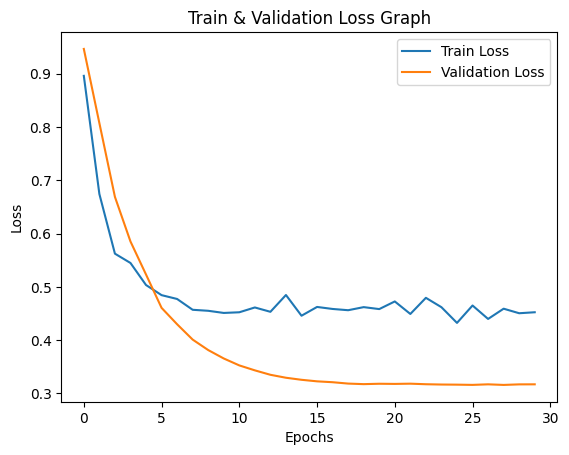

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Train & Validation Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy Graph

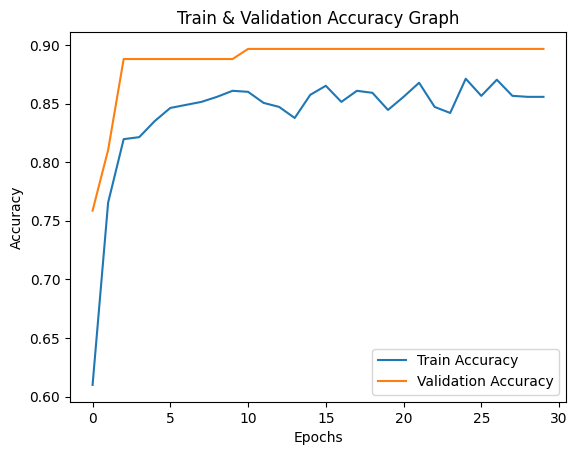

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Train & Validation Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model Test

In [ ]:
test_loss, test_accuracy = res_edit_model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 310ms/step - loss: 0.2758 - accuracy: 0.9333
Test Loss:  0.2758137881755829
Test Accuracy: 0.9333333373069763


# d

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.000001, verbose=1)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, Nadam

res_edit_model.compile(optimizer = Nadam(learning_rate = 0.001),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

In [ ]:
EPOCH = 30
BATCH_SIZE = 32

# 모델 훈련
history = res_edit_model.fit(X_train, y_train, epochs = EPOCH,
                             batch_size = BATCH_SIZE,
                             validation_data = (X_val, y_val), verbose = 1,
                             callbacks = [reduce_lr])

Epoch 1/30
37/37 [==============================] - 190s 858ms/step - loss: 0.4420 - accuracy: 0.8411 - val_loss: 7.8340 - val_accuracy: 0.0431 - lr: 0.0010
Epoch 2/30
37/37 [==============================] - 29s 786ms/step - loss: 0.4029 - accuracy: 0.8574 - val_loss: 39.4699 - val_accuracy: 0.1207 - lr: 0.0010
Epoch 3/30
37/37 [==============================] - 29s 776ms/step - loss: 0.3939 - accuracy: 0.8557 - val_loss: 0.5262 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 4/30
37/37 [==============================] - 29s 781ms/step - loss: 0.4002 - accuracy: 0.8402 - val_loss: 1.3052 - val_accuracy: 0.7069 - lr: 0.0010
Epoch 5/30
37/37 [==============================] - 29s 782ms/step - loss: 0.3599 - accuracy: 0.8625 - val_loss: 3.2130 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 6/30
37/37 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8763
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
37/37 [==============================] - 29s 78

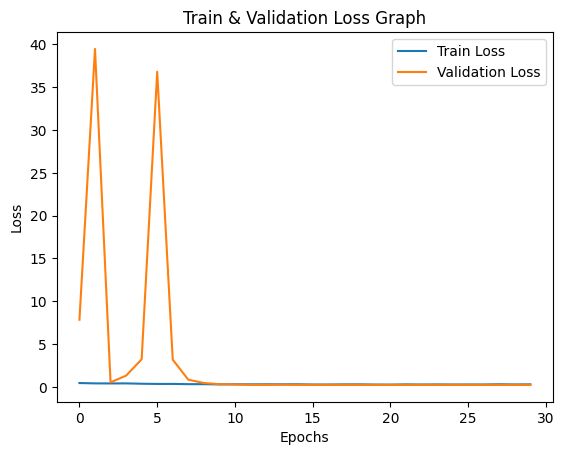

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Train & Validation Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

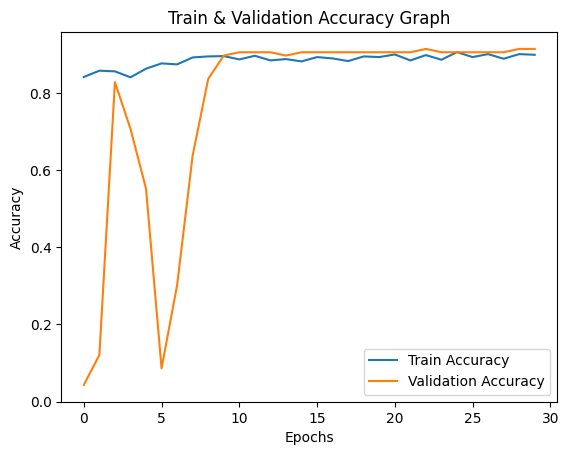

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Train & Validation Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = res_edit_model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 283ms/step - loss: 0.1784 - accuracy: 0.9333
Test Loss:  0.17841704189777374
Test Accuracy: 0.9333333373069763
